# Data

Graphs $G= (V,E)$ are represented by a set of vertices or nodes $ v \in V $ and edges or bonds $e_{v,w} = (v, w) \in E$ between them. For Machine learning (ML) vertices and edges are attributed with feature information.

To handle graphs, [NetworkX](https://networkx.org/documentation/stable/index.html) is a Python package for the creation, manipulation, and functions of complex networks. 
The graph types are provided by following classes in NetworkX:

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.Graph()
G = nx.DiGraph()
G = nx.MultiGraph()
G = nx.MultiDiGraph()

see [introduction](https://networkx.org/documentation/stable/reference/introduction.html) on NetworkX [docs](https://networkx.org/documentation/stable/index.html):

* ``Graph`` This class implements an undirected graph. It ignores multiple edges between two nodes. It does allow self-loop edges between a node and itself.
* ``DiGraph`` Directed graphs, that is, graphs with directed edges. Provides operations common to directed graphs, (a subclass of Graph).
* ``MultiGraph`` A flexible graph class that allows multiple undirected edges between pairs of nodes. The additional flexibility leads to some degradation in performance, though usually not significant.
* ``MultiDiGraph`` A directed version of a MultiGraph.

Here an example on how a graph is constructed from node and edge information.

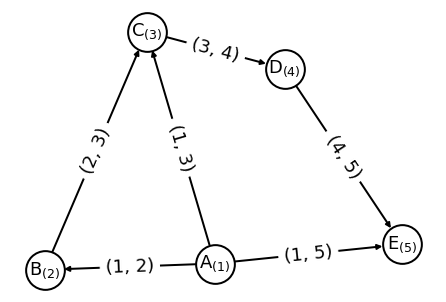

In [2]:
# Graph information as arrays.
node_number = [1, 2, 3, 4, 5]
node_attributes = ["A", "B", "C", "D", "E"]
edge_indices = [(1, 2), (1, 3),(1, 5), (2, 3), (3, 4), (4, 5)]

# Setup graph.
G = nx.DiGraph()
G.add_nodes_from(node_number)
G.add_edges_from(edge_indices)
pos = nx.spring_layout(G, seed=42)
options = {
    "font_size": 18,
    "node_size": 1500,
    "node_color": "white",
    "edgecolors": "black",
    "linewidths": 2,
    "width": 2,
}
nx.draw(G, pos, labels={i: "%s$_{(%s)}$" % (x, i) for i, x in zip(node_number, node_attributes)}, 
        with_labels=True, **options)
nx.draw_networkx_edge_labels(G,pos, edge_labels={x: x for x in G.edges()}, font_size=18);

There are some data classes in `kgcnn` that can help to store and load graph data. In principle a graph is a collection of the follwing objects in tensor-form:

* `nodes_attributes`: Node features of shape `(N, F)` where N is the number of nodes and F is the node feature dimension.
* `edge_indices`: Connection list of shape `(M, 2)` where M is the number of edges. The indices denote a connection of incoming or receiving node `i` and outgoing or sending node `j` as `(i, j)`.
* `edges_attributes`: Edge features of shape `(M, F)` where M is the number of edges and F is the edge feature dimension.
* `graph_attributes`: Graph state information of shape `(F, )` where F denotes the feature dimension.

These can be stored in form of numpy arrays in a dictionary type container `GraphDict`. Additional train/test assignment, labels, positions/coordinates, forces or momentum, other connection indices or even symbols or IDs can be added to this dictionary. 

For multiple small graphs a list of these dictionaries serves to represent the common case of datasets for supervised learning tasks, for example small molecules or crystal structures.


> **NOTE**: There are functions to import and export to [NetworkX](https://networkx.org/documentation/stable/index.html).

## Graph Dict

Graphs are represented by a dictionary `GraphDict` of (numpy) arrays which behaves like a python dict. In principle the `GraphDict` can take every key and value pair via item operator `[]`. However, for consitency and class methods, keys must be string-names and values `np.ndarray` . You can use `set` and `get` to auto-cast to numpy arrays or run `validate()`. 

In [3]:
import numpy as np
from kgcnn.data.base import GraphDict
# Single graph.
graph = GraphDict({"edge_indices": np.array([[1, 0], [0, 1]]), "node_label":  np.array([[0], [1]])})
graph.set("graph_labels",  np.array([0]))
graph.set("edge_attributes", np.array([[1.0], [2.0]]));
print({key: value.shape for key, value in graph.items()})
print("Is dict: %s" % isinstance(graph, dict))
print("Graph label", graph["graph_labels"])

{'edge_indices': (2, 2), 'node_label': (2, 1), 'graph_labels': (1,), 'edge_attributes': (2, 1)}
Is dict: True
Graph label [0]


The class `GraphDict` can be converted to for example a strict graph representation of `networkx` which keeps track of node and edge changes.

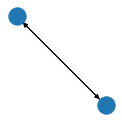

In [4]:
import networkx as nx
import matplotlib.pyplot as plt
nx_graph = graph.to_networkx()
plt.figure(figsize=(1.5,1.5)) 
nx.draw(nx_graph)
plt.show()

Or compiling a dictionary of (tensorial) graph properties from a `networkx` graph.

In [5]:
graph = GraphDict().from_networkx(nx.cubical_graph())
print({key: value.shape for key, value in graph.items()})

{'node_number': (8,), 'edge_indices': (12, 2)}


There are graph pre- and postprocessors in `kgcnn.graph` which take specific properties by name and apply a processing function or transformation. The processing function can for example compute angle indices based on edges or sort edge indices and sort dependent features accordingly. 

> **WARNING**: However, they should be used with caution since they only apply to tensor data regardless of any underlying graph structure. Meaning, if you for example remove nodes, you must take care that the respective edges are removed as well. This is different from a `networkx` which limits access to basic gaph manipulation operations. 


For example `SortEdgeIndices` can sort an "edge_indices" tensor and sort attributed properties such as "edge_attributes" or "edge_labels" or a list of multiple (named) properties accordingly. In the example below a generic search string is also valid. To directly update a `GraphDict` make a preprocessor with `in_place=True` . Note that preprocessors can be serialised and have a `get_config` method.

In [6]:
from kgcnn.graph.preprocessor import SortEdgeIndices, AddEdgeSelfLoops, SetEdgeWeightsUniform

SortEdgeIndices(edge_indices="edge_indices", edge_attributes="^edge_(?!indices$).*", in_place=True)(graph)

SetEdgeWeightsUniform(edge_indices="edge_indices", value=1.0, in_place=True)(graph)

AddEdgeSelfLoops(
    edge_indices="edge_indices", edge_attributes="^edge_(?!indices$).*", 
    remove_duplicates=True, sort_indices=True, fill_value=0, in_place=True)(graph);

print({key: value.shape for key, value in graph.items()})

{'node_number': (8,), 'edge_indices': (20, 2), 'edge_weights': (20, 1)}


## Graph List

A `MemoryGraphList` should behave identical to a python list but contain only `GraphDict` items.
Here a few examples with some utility methods of the class.

In [7]:
from kgcnn.data.base import MemoryGraphList

# List of graph dicts.
graph_list = MemoryGraphList([
    GraphDict({"edge_indices": [[0, 1], [1, 0]], "graph_label": [0]}), 
    GraphDict({"edge_indices": [[0, 0]], "graph_label": [1]}), 
    GraphDict({"graph_label": [0]})
])
print("Is list: %s" % isinstance(graph_list, list))

# Remove graphs without certain property
graph_list.clean(["edge_indices"])
print("New length of graph:", len(graph_list))

# Go to every graph dict and take out the requested property. Opposite is set().
print("Labels (list):", graph_list.get("graph_label"))

# Or directly modify list.
for i, x in enumerate(graph_list):
    x.set("graph_number", [i])

print(graph_list)  # Also supports indexing lists.

INFO:kgcnn.data.base:Property 'edge_indices' is not defined for graph '2'.


Is list: True
New length of graph: 2
Labels (list): [array([0]), array([1])]
<MemoryGraphList [{'edge_indices': array([[0, 1],
       [1, 0]]), 'graph_label': array([0]), 'graph_number': array([0])} ...]>


It is also easy to map a method over the graph dicts in the list. This can be a class method of `GraphDict` or a callable function (or class). Or for compatibility reasons a default name of a preprocessor (not to be used in the future).

In [8]:
graph_list.map_list(method=AddEdgeSelfLoops(edge_indices="edge_indices", in_place=True))

# Note: Former deprecated option is to use a method name that is looked up in the preprocessor class.
# graph_list.map_list(method="add_edge_self_loops")

<MemoryGraphList [{'edge_indices': array([[0, 0],
       [0, 1],
       [1, 0],
       [1, 1]]), 'graph_label': array([0]), 'graph_number': array([0])} ...]>

Most importantly, a (ragged) tensor for the complete list can be generated for the input required for a specific keras model. You can simply pass a list or dict of the config of keras Input layers as shown below:

In [9]:
graph_list.tensor([
    {"name": "edge_indices", "shape": (None, 2), "ragged": True, "dtype": "int64"},
    {"name": "graph_label", "shape": (1, ), "ragged": False}
])

[<tf.RaggedTensor [[[0, 0],
   [0, 1],
   [1, 0],
   [1, 1]], [[0, 0]]]>,
 <tf.Tensor: shape=(2, 1), dtype=int32, numpy=
 array([[0],
        [1]])>]

## Datasets

The `MemoryGraphDataset` inherits from `MemoryGraphList` but must be initialized with file information on disk that points to a `data_directory` for the dataset. The `data_directory` can have a subdirectory for files and/or single file such as a CSV file. The usual data structure looks like this:

```bash
├── data_directory
    ├── file_directory
    │   ├── *.*
    │   └── ... 
    ├── file_name
    └── dataset_name.kgcnn.pickle
```

In [10]:
from kgcnn.data.base import MemoryGraphDataset
dataset = MemoryGraphDataset(
    data_directory=".",  # Path to file directory or current folder
    dataset_name="Example",
    file_name=None, file_directory=None)

# Modify like a MemoryGraphList
for x in graph_list:
    dataset.append(x)
dataset[0]["node_attributes"] = np.array([[0.9, 3.2], [1.2, 2.4]])
print(dataset)

<MemoryGraphDataset [{'edge_indices': array([[0, 0],
       [0, 1],
       [1, 0],
       [1, 1]]), 'graph_label': array([0]), 'graph_number': array([0]), 'node_attributes': array([[0.9, 3.2],
       [1.2, 2.4]])} ...]>


You can also change the location on file with `relocate()` . Note that in this case only the file information is changed,
but no files are moved or copied. Save the dataset as pickled python list of python dicts to file:

In [11]:
dataset.save()
dataset.load()

INFO:kgcnn.data.Example:Pickle dataset...
INFO:kgcnn.data.Example:Load pickled dataset...


<MemoryGraphDataset [{'edge_indices': array([[0, 0],
       [0, 1],
       [1, 0],
       [1, 1]]), 'graph_label': array([0]), 'graph_number': array([0]), 'node_attributes': array([[0.9, 3.2],
       [1.2, 2.4]])} ...]>

### Special Datasets

From `MemoryGraphDataset` there are many subclasses `QMDataset`, `MoleculeNetDataset`, `CrystalDataset`, `VisualGraphDataset` and `GraphTUDataset` which further have functions required for the specific dataset type to convert and process files such as '.txt', '.sdf', '.xyz', '.cif', '.jpg' etc. 
They are located in `kgcnn.data` .
Most subclasses implement `prepare_data()` and `read_in_memory()` with dataset dependent arguments to preprocess and finally load data from different formats.


In [data.datasets](https://github.com/aimat-lab/gcnn_keras/tree/master/kgcnn/data/datasets) there are graph learning benchmark datasets as subclasses which are being *downloaded* from e.g. popular graph archives like [TUDatasets](https://chrsmrrs.github.io/datasets/), [MatBench](https://matbench.materialsproject.org/) or [MoleculeNet](https://moleculenet.org/). 
The subclasses `GraphTUDataset2020`, `MatBenchDataset2020` and `MoleculeNetDataset2018` download and read the available datasets by name.
There are also specific dataset subclasses for each dataset to handle additional processing or downloading from individual sources:

In [12]:
from kgcnn.data.datasets.MUTAGDataset import MUTAGDataset
dataset = MUTAGDataset()  # inherits from GraphTUDataset2020()
dataset[0].keys()

INFO:kgcnn.data.download:Checking and possibly downloading dataset with name MUTAG
INFO:kgcnn.data.download:Dataset directory located at C:\Users\patri\.kgcnn\datasets
INFO:kgcnn.data.download:Dataset directory found. Done.
INFO:kgcnn.data.download:Dataset found. Done.
INFO:kgcnn.data.download:Directory for extraction exists. Done.
INFO:kgcnn.data.download:Not extracting zip file. Stopped.
INFO:kgcnn.data.MUTAG:Reading dataset to memory with name MUTAG
INFO:kgcnn.data.MUTAG:Shift start of graph ID to zero for 'MUTAG' to match python indexing.
INFO:kgcnn.data.MUTAG:Graph index which has unconnected '[]' with '[]' in total '0'.


dict_keys(['node_degree', 'node_labels', 'edge_indices', 'edge_labels', 'graph_labels', 'node_attributes', 'edge_attributes', 'node_symbol', 'node_number', 'graph_size'])

Downloaded datasets are stored in `~/.kgcnn/datasets` on your computer. Please remove them manually, if no longer required.

Here are some examples on custom usage of the base classes:

#### MoleculeNetDatasets

Class for using [MoleculeNet](https://moleculenet.org/) datasets. The concept is to load a table of smiles and corresponding targets and convert them into a tensor representation for graph networks. The column that contains smiles must be specified in the `prepare_data` method.

Attribute generation is carried out via the `MolecularGraphRDKit` class and requires RDKit as backend.
You can also use a pre-processed SDF or SMILES file in *data_directory* and add their name in the
class initialization.


The graph structure matches the molecular graph, i.e. the chemical structure. The atomic coordinates
are generated by a conformer guess. Since this require some computation time, it is only done once and the
molecular coordinate or mol-blocks stored in a single SDF file with the base-name of the csv ``file_name``.
Conversion is using the `MolConverter` class.

The selection of smiles and whether conformers should be generated is handled by subclasses or specified in
the methods `prepare_data` and `read_in_memory`, see the documentation of the methods for further details.

Attribute generation is carried out via the `MolecularGraphRDKit` class and requires RDKit as backend.
You can also use a pre-processed SDF or SMILES file in `data_directory` and add their name in the
class initialization.

The file structure is:


```bash
├── ExampleMol
    ├── data.csv
    ├── data.SMILES  # After prepare_data
    └── data.sdf  # After prepare_data
```

Example data:

In [13]:
import os
os.makedirs("DatasetMol", exist_ok=True)

with open("DatasetMol/data.csv", "w") as f:
    f.write("".join([
        "smiles,Values1,Values2\n",  # Need header!
        "CCC, 1, 0.1\n",
        "CCCO, 2, 0.3\nCCCN, 3, 0.2\n",
        "CCCC=O, 4, 0.4\n"
        "NOCF, 4, 1.4\n"
    ]))

Setting up dataset and run `prepare_data()` and `read_in_memory()`.

In [14]:
from kgcnn.data.moleculenet import MoleculeNetDataset, OneHotEncoder
dataset = MoleculeNetDataset(
    file_name="data.csv", 
    file_name_mol=None,  # Default will be data.sdf
    data_directory="DatasetMol/", 
    dataset_name="Example"
)
dataset.prepare_data(
    overwrite=False, 
    smiles_column_name="smiles",  # Name of the column in CSV File.
    add_hydrogen=True,
    sanitize=True,
    make_conformers=True,
    optimize_conformer=True,
    num_workers=None  # Default is #cpus
)
dataset.read_in_memory(
    nodes=None,  # Use Default attributes selection.
    edges=None,  # Use Default attributes selection.
    graph=None,  # Use Default attributes selection.
    encoder_nodes=None,  # Use Default encoder.
    encoder_edges=None,  # Use Default encoder.
    encoder_graph=None,  # Use Default encoder.
    label_column_name=["Values1", "Values2"],  # Graph labels from CSV!
    add_hydrogen=False,  # We remove H's 
    has_conformers=True,  # We keep strucutre
    compute_partial_charges=False,
    make_directed=False,
    sanitize=True,
    additional_callbacks=None,
    custom_transform=None
)
print("Number of graphs:", len(dataset))

ERROR:root:Module 'mol' is deprecated and will be removed in future versions. Please move to 'kgcnn.molecule'.
ERROR:kgcnn.molecule.convert:Can not import `RDKit` package for conversion.
INFO:kgcnn.data.Example:Found SDF DatasetMol/data.sdf of pre-computed structures.
INFO:kgcnn.data.Example:Read molecules from mol-file.
INFO:kgcnn.data.Example: ... process molecules 0 from 5
INFO:kgcnn.molecule.encoder:OneHotEncoder Symbol found ['C', 'O', 'N', 'F']
INFO:kgcnn.molecule.encoder:OneHotEncoder Hybridization found [rdkit.Chem.rdchem.HybridizationType.SP3, rdkit.Chem.rdchem.HybridizationType.SP2]
INFO:kgcnn.molecule.encoder:OneHotEncoder TotalDegree found [4, 2, 3, 1]
INFO:kgcnn.molecule.encoder:OneHotEncoder TotalNumHs found [3, 2, 1, 0]
INFO:kgcnn.molecule.encoder:OneHotEncoder CIPCode found [None]
INFO:kgcnn.molecule.encoder:OneHotEncoder ChiralityPossible found [None]
INFO:kgcnn.molecule.encoder:OneHotEncoder BondType found [rdkit.Chem.rdchem.BondType.SINGLE, rdkit.Chem.rdchem.BondType

Number of graphs: 5


It is possible to further customize the attribute generation. For mor details, see documentation on `MolecularGraphRDKit` classes. 

Options woule be a function that receive atom, bond or molecule instances of the mol-backend and must return a list or value for the attribute of the specific atom or bond, a callback that gets a `MolecularGraphRDKit` and the row of the CSV file as arguments or a transformation method that modifies the `MolecularGraphRDKit` instance one time before attribute generation. Note that for `set_attributes` the data is read from the SDF file and processed again. 

In [15]:
# Via RDKit function.
def mol_feature(m):
    return m.GetNumAtoms()
# Via callback.
def graph_size_callback(mg, ds):
    return mg.mol.GetNumAtoms()
# Via transform.
def custum_trafo(mg):
    return mg.compute_partial_charges()

In [16]:
dataset.set_attributes(
    # Nodes
    nodes=["Symbol", "TotalNumHs", "GasteigerCharge"], 
    encoder_nodes={
        "Symbol": OneHotEncoder(["C", "N", "O"], dtype="str", add_unknown=False)
    },
    # Edges
    edges=["BondType", "Stereo"], 
    encoder_edges = {
        "BondType": int
    },
    # Graph-level
    graph=["ExactMolWt", mol_feature],
    additional_callbacks= {"size": graph_size_callback},
    custom_transform=custum_trafo
)

INFO:kgcnn.data.Example:Read molecules from mol-file.
INFO:kgcnn.data.Example: ... process molecules 0 from 5
INFO:kgcnn.molecule.encoder:OneHotEncoder Symbol found ['C', 'O', 'N', 'F']


<MoleculeNetDataset [{'node_symbol': array(['C', 'C', 'C'], dtype='<U1'), 'node_number': array([6, 6, 6]), 'edge_indices': array([[0, 1],
       [1, 0],
       [1, 2],
       [2, 1]], dtype=int64), 'edge_number': array([1, 1, 1, 1]), 'graph_size': array(3), 'node_coordinates': array([[ 0.995 ,  0.0682,  0.0729],
       [ 2.515 ,  0.0682,  0.0729],
       [ 3.0216, -1.244 ,  0.6489]]), 'graph_labels': array([1, 0.1], dtype=object), 'node_attributes': array([[ 1.        ,  0.        ,  0.        ,  3.        , -0.06564544],
       [ 1.        ,  0.        ,  0.        ,  2.        , -0.05903836],
       [ 1.        ,  0.        ,  0.        ,  3.        , -0.06564544]],
      dtype=float32), 'edge_attributes': array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32), 'graph_attributes': array([44.0626,  3.    ], dtype=float32), 'size': array(3)} ...]>

#### QMDataset

A base class for QM (quantum mechanical) datasets.

It generates atoms and coordinates from a single xyz-file, which stores atomic coordinates, and infers graph properties similar to `MoleculeNetDataset` . 
Furthermore, labels are given by an additional CSV or table file.
Additionally, loading multiple xyz-files into one single xyz-file is supported. The (ordered) file names must be given in the CSV or table file. 
The table file must have one line of header with column names!

It should be possible to generate approximate chemical bonding information via `rdkit` and/or `openbabel`, if `openbabel` package is installed (`rdkit` is installed by default). The class inherits from `MemoryGraphDataset` .
If conversion is not successful minimal loading of labels and coordinates should be supported.

For additional attributes, the `set_attributes` enables further features that require `rdkit` or `openbabel`
to be installed.
Note that for QMDataset the mol-information, if it is generated, is not cleaned during reading by default.


The file structure is:


```bash
├── ExampleQM
    ├── qm.csv
    ├── XYZ_files  # Need a qm.csv with column of files, if multiple files are used.
    │   ├── *.*
    │   └── ... 
    ├── qm.xyz  # If available, otherwise will be created.
    └── qm.sdf  # After prepare_data
```

Example data:

In [17]:
import os
os.makedirs("DatasetQM", exist_ok=True)
os.makedirs("DatasetQM/XYZ_files", exist_ok=True)
xyz_list = [
    "3\n\nC -0.8513 1.7563 0.5028\nC -1.1415 0.2664 0.4371\nC -0.7681 -0.3186 -0.9144\n",
    "4\n\nC 2.4098 0.5514 -2.1836\nC 2.5000 -0.4800 -1.0676\nC 1.1575 -0.7559 -0.3909\nN 0.6356 0.4257 0.2851\n",
    "1\n\nC 0.0 0.0 0.0\n"
]
for i, x in enumerate(xyz_list):
    with open("DatasetQM/XYZ_files/mol_%i.xyz" % i, "w") as f:
        f.write(x)
with open("DatasetQM/qm.csv", "w") as f:
    f.write("ID,files,energy\n0,mol_0.xyz,-13.0\n1,mol_1.xyz,-20.0\n2,mol_2.xyz,-34.0")

Setting up dataset and run `prepare_data()` and `read_in_memory()` . Note that `read_in_memory` reads the single SDF (preferred) or XYZ-file into memory together with the CSV file with labels. Attributes can be used identical to ``MoleculeNetDataset`` if SDF file was generated.

In [18]:
import numpy as np
from kgcnn.data.qm import QMDataset
dts = QMDataset(
    file_name="qm.csv",
    file_name_xyz=None,  # Uses default naming. Will be generated.
    file_name_mol=None,  # Uses default naming. Will be generated.
    file_directory="XYZ_files",
    data_directory="DatasetQM", 
    dataset_name="ExampleQM"
)
dts.prepare_data(
    overwrite=False,  # Can be set to True to rerun data preparation.
    file_column_name="files",  # Column in CSV: Necessary for multiple xyz files to make a single xyz file.
    make_sdf=True  # Only work for optimized molecules.
)
dts.read_in_memory(
    label_column_name="energy",  # Column in CSV
    # Optional graph attributes if SDF was created, otherwise only xyz information.
    nodes=None,  # Use Default attributes selection.
    edges=None,  # Use Default attributes selection.
    graph=None,  # Use Default attributes selection.
    encoder_nodes=None,  # Use Default encoder.
    encoder_edges=None,  # Use Default encoder.
    encoder_graph=None,  # Use Default encoder.
    add_hydrogen=True,  # Should be considered for QM data.
    make_directed=False,
    sanitize=False,  # Should be False since QM may not always have valid valence.
    compute_partial_charges=False,
    additional_callbacks=None,
    custom_transform=None
)

INFO:kgcnn.data.ExampleQM:Found SDF file 'DatasetQM\qm.sdf' of pre-computed structures.
INFO:kgcnn.data.ExampleQM:Reading structures from SDF file.
INFO:kgcnn.data.ExampleQM: ... process molecules 0 from 3


<QMDataset [{'node_symbol': array(['C', 'C', 'C'], dtype='<U1'), 'node_number': array([6, 6, 6]), 'node_coordinates': array([[-0.8513,  1.7563,  0.5028],
       [-1.1415,  0.2664,  0.4371],
       [-0.7681, -0.3186, -0.9144]]), 'edge_indices': array([[0, 1],
       [1, 0],
       [1, 2],
       [2, 1]], dtype=int64), 'edge_number': array([1, 1, 1, 1]), 'graph_labels': array(-13.)} ...]>

#### CrystalDataset

Class for making graph dataset from periodic structures such as crystals.

The dataset class requires a *data_directory* to store a table '.csv' file containing labels and information
of the structures stored in multiple (CIF, POSCAR, ...) files in `file_directory`.
The file names must be included in the '.csv' table. The table file must have one line of header with column names!

This class uses `pymatgen.core.structure.Structure` and therefore requires `pymatgen` to be installed.
A '.pymatgen.json' serialized file is generated to store a list of structures from multiple '.cif' files via
`prepare_data()`. The json file is then read by `read_in_memory` .

Consequently, a 'file_name.pymatgen.json' can be directly stored in `data_directory`.
In this, case `prepare_data()` does not have to be used. Additionally, a table file 'file_name.csv'
that lists the single file names and possible labels or classification targets is required.


The file structure is:


 ```bash
 ├── data_directory
    ├── file_directory
    │   ├── *.cif
    │   ├── *.cif
    │   └── ...
    ├── file_name.csv
    └── file_name.pymatgen.json
 ```
 
 Example data.

In [19]:
import pymatgen
import pymatgen.core.structure
test_data = [
    pymatgen.core.Structure(lattice=np.array([[4.34157255, 0., 2.50660808], [1.44719085, 4.09327385, 2.50660808], [0., 0., 5.01321616]]), species=["Te", "Ba"], coords=np.array([[0.5, 0.5, 0.5], [0. , 0. , 0. ]])),
    pymatgen.core.Structure(lattice=np.array([[2.95117784, 0., 1.70386332], [0.98372595, 2.78239715, 1.70386332], [0., 0., 3.40772664]]), species=["B", "As"], coords=np.array([[0.25, 0.25, 0.25], [0. , 0. , 0. ]])),
    pymatgen.core.Structure(lattice=np.array([[4.3015, 0., 0.],[-2.15075, 3.725208, 0.], [0., 0., 5.2703]]), species=["Ba", "Ga", "Si", "H"], coords=np.array([[0., 0., 0.],[0.6666, 0.3333, 0.5423], [0.3334, 0.6667, 0.4555], [0.6666, 0.3333, 0.8759]])),
]
os.makedirs("DatasetCrystal", exist_ok=True)
os.makedirs("DatasetCrystal/CifFiles", exist_ok=True)
for i, x in enumerate(test_data):
    x.to(filename="DatasetCrystal/CifFiles/file_%s.cif" % i, fmt="cif")
csv_data = "".join([
    "file_name,index,label\n",  # Need header!
    "file_0.cif, 0, 98.58577122703691\n",
    "file_1.cif, 1, 701.5857233477558\n",
    "file_2.cif, 2, 1138.5856886491724"
])
with open("DatasetCrystal/data.csv", "w") as f:
    f.write(csv_data)

Setting up dataset and run `prepare_data()` and `read_in_memory()` .

In [20]:
from kgcnn.data.crystal import CrystalDataset
dataset = CrystalDataset(
    data_directory="DatasetCrystal/", 
    dataset_name="ExampleCrystal", 
    file_name="data.csv", 
    file_directory="CifFiles",
    file_name_pymatgen_json=None, # Use default name, will be generated.
)
dataset.prepare_data(
    file_column_name="file_name", 
    overwrite=False
)
dataset.read_in_memory(
    label_column_name="label",
    additional_callbacks=None,  # Custom callbacks for additional properties.
)

INFO:kgcnn.data.ExampleCrystal:Pickled pymatgen structures already exist. Do nothing.
INFO:kgcnn.data.ExampleCrystal:Making node features from structure...
INFO:kgcnn.data.ExampleCrystal:Reading structures from .json ...
INFO:kgcnn.data.ExampleCrystal: ... read structures 0 from 3


<CrystalDataset [{'graph_labels': array(98.58577123), 'node_coordinates': array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.31245659e-09, 6.13991078e+00, 2.27324426e-09]]), 'node_frac_coordinates': array([[0. , 0. , 0. ],
       [0.5, 0.5, 0.5]]), 'graph_lattice': array([[ 1.44719085e+00,  4.09327385e+00,  2.50660808e+00],
       [ 1.44719085e+00,  4.09327385e+00, -2.50660808e+00],
       [-2.89438170e+00,  4.09327385e+00,  1.51549528e-09]]), 'abc': array([5.01321616, 5.01321616, 5.01321616]), 'charge': array([0.]), 'volume': array([89.0910946]), 'node_number': array([56, 52])} ...]>

For additional crystal graph representations such as multigraphs and nearest neighbour connections use `set_representation()` .

In [21]:
# In development
# dataset.set_representation(pre_processor, reset_graphs=False)

#### GraphTUDataset

Base class for loading graph datasets published by [TU Dortmund University](https://chrsmrrs.github.io/datasets)

Datasets contain non-isomorphic graphs for many graph classification or regression tasks.
This general base class has functionality to load TUDatasets in a generic way.
The datasets are already in a graph-like format and do not need further processing via e.g. `prepare_data`.

> **NOTE**:  Note that subclasses of `GraphTUDataset2020` in `kgcnn.data.datasets` downloads datasets, There are also further TU-datasets in `kgcnn.data.datasets`, if further processing is used in literature. Not all datasets can provide all types of graph properties like `edge_attributes` etc.

The file structure of `GraphTUDataset` for a given dataset 'DS' (replace DS with dataset name).

Setting up a single file can be made additionally with base class `save` method.

```bash
├── data_directory
    ├── DS_graph_indicator.txt
    ├── DS_A.txt
    ├── DS_node_labels.txt
    ├── DS_node_attributes.txt
    ├── DS_edge_labels.txt
    ├── DS_edge_attributes.txt
    ├── DS_graph_labels.txt
    ├── DS_graph_attributes.txt
    └── ...
```

Example data:

In [22]:
import os
os.makedirs("DatasetTUD/", exist_ok=True)
with open("DatasetTUD/Example_A.txt", "w") as f:
    f.write("1, 2\n2, 1\n3, 3\n3, 4\n4, 4\n")
with open("DatasetTUD/Example_graph_indicator.txt", "w") as f:
    f.write("1\n1\n2\n2")

Setting up dataset and `read_in_memory()` .

In [23]:
from kgcnn.data.tudataset import GraphTUDataset
dataset = GraphTUDataset(
    data_directory="DatasetTUD",
    dataset_name="Example"
    # file_name, file_directory as not used here.
)
dataset.read_in_memory()

INFO:kgcnn.data.Example:Reading dataset to memory with name Example
INFO:kgcnn.data.Example:Shift start of graph ID to zero for 'Example' to match python indexing.
INFO:kgcnn.data.Example:Graph index which has unconnected '[]' with '[]' in total '0'.


<GraphTUDataset [{'node_degree': array([1, 1]), 'edge_indices': array([[1, 0],
       [0, 1]])} ...]>

> **NOTE**: You can find this page as jupyter notebook in https://github.com/aimat-lab/gcnn_keras/tree/master/docs/source